[【Python】金利データの取得](https://note.com/hippen/n/n45aace7102b4)

In [65]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns


# yahoo finance連携用モジュール
!pip install yfinance
import yfinance as yf

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# FREDから金利情報等を入手

## 金利情報

政策金利情報: [FRB Rates - discount, fed funds, primary credit](https://fred.stlouisfed.org/categories/118)
[Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FF)

- [政策金利 (Effective Federal Funds Rate)](https://fred.stlouisfed.org/categories/118): `FF`


名目・実質金利情報: [Treasury Constant Maturity](https://fred.stlouisfed.org/categories/115)

- 名目金利 (Constant Maturity Treasury, CMT) : `DGS2`, `DGS5`など`DGS`と年数のTicker名。1monthから30yearsまである。
- 実質金利 (Treasury Inflation-Indexed Security, Constant Maturity): `DFII5`, `DFII10`など`DFII`と年数のTicker名

## インフレ率

[Insterest Rate Spreads](https://fred.stlouisfed.org/categories/33446)から入手
- 期待インフレ率(Break Even Inflation Rate, BEI): `T10YIE`など`T`のあとに年数。付きデータが有るときには`T20YIEM`など最後に`M`がつく
- 金利差(10年名目金利-2年名目金利): `T10Y2Y`

In [77]:
table_yields = {
    "FF": "Effective Federal Funds Rate",
    "DGS1": "1-Year Constant",
    "DGS2": "2-Year Constant",
    "DGS5": "5-Year Constant",
    "DGS10": "10-Year Constant",
    "DGS30": "30-Year Constant",
    "DFII5": "5-Year Inflation-Indexed",
    "DFII10": "10-Year Inflation-Indexed",
    "DFII30": "30-Year Inflation-Indexed",
    "T10YIE": "10-Year Inflation",
    "T20YIEM": "20-Year Inflation",
    "T10Y2Y": "10-Year - 2 Year",
    "GOLD": "GOLD",
    "SPY": "SPY",
    "QQQ": "QQQ",
}


def defaultPlotting():
    sns.set_theme(
        rc={
            "figure.figsize": (6, 5),
            "axes.titlesize": 20,
            "axes.labelsize": 20,
            "font.size": 20,
            "legend.fontsize": 15,
        },
        style="white",
    )
    sns.set_style("whitegrid")


def get_stock_data(start, end, codelist):
    data = yf.download(codelist, start, end)

    #  display(data)
    return data["Adj Close"]  # Adjusted Close (配当込み，分割調整値)


def plot(df, xlim=None, ylim=None, ylabel="", normalize=False):
    if normalize == True:
        if xlim == None:
            df = df.apply(lambda x: x / x[0])
        else:
            df = df[xlim[0]:xlim[1]].dropna().apply(lambda x: x / x[0])

    df = df.rename(columns=table_yields)

    ax= df.plot(
        figsize=(14, 5.5),
        fontsize=15,
        linewidth=1.5,
        alpha=0.8,
        xlim=xlim,
        ylim=ylim
    )
    plt.legend(fontsize=10)
    #    plt.title("Yields", fontsize=45)

    plt.axhline(y=0, color="gray", linewidth=2)
    plt.xlabel("")
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(rotation=90)
    plt.minorticks_on()
    plt.grid(which="major", ls="-")
    plt.grid(which="minor", ls="dashed")

    plt.axvline(x="2013-05-22", linewidth=1, color="b", ls="--", alpha=0.8)
    plt.axvline(x="2013-06-19", linewidth=1, color="b", ls="--", alpha=0.8)
    
    plt.axvline(x="2014-01-01", linewidth=1, color="r", ls="--", alpha=0.8)
    plt.axvline(x="2014-10-29", linewidth=1, color="r", ls="--", alpha=0.8)
    plt.fill_between(["2014-01-01","2014-10-29"],[ylim[1],ylim[1]],color="red",alpha=0.05)
    

    plt.show()

In [8]:
# start = datetime.date.today() - datetime.timedelta(days=1000)
start = datetime.date(2001, 1, 1)
end = datetime.date.today()

yields = ["FF", "DGS2", "DGS5", "DGS10", "DGS30", "DFII5", "DFII10", "DFII30", "T10Y2Y"]

df_yields = web.DataReader(yields, "fred", start, end)
df_yields = df_yields.fillna(method="ffill")

In [58]:
tickers = ["GC=F", "SPY", "QQQ", "TLT", "SHY","XLF","EDV"]
df_stocks = get_stock_data(
    start,
    end,
    tickers
)

[*********************100%***********************]  7 of 7 completed


In [59]:
df=pd.concat([df_yields,df_stocks],axis=1)

Yosshiさんの真似をして2013年から2018金利の推移のグラフを作ってみました。
- 上のグラフが金利(政策金利, 2年,10年,30年，金利差(10年-2年))
- 2013/5/22(青破線) バーナンキ発言(テーパリング示唆)
- 2013/6/19(青破線) FOMC(テーパリング発表)
- 2014/1/1-2014/10(薄赤領域) テーパリング期間

わかること
- テーバリング示唆で金利上昇
- テーパリング開始後は短期金利以外は下がっている
- 2016年からの政策金利引き上げでも長期金利は一旦下がる。(半年以上!)

下にある図はSPY, QQQ, TLT, SHY, XLF, EDVの値動きです。

わかること
- SPY, QQQは凸凹はあるもののテーパリング期間はちゃんと上昇している
- 政策金利の引き上げ後に，SPY,QQQの大きな下げがあった。(少し前にもあった)
- XLFとSPYは政策金利引き上げ前はあまり変わらない。引き上げ後にXLFはのびているが，このとき金利差が必ずしも大きくなっているわけではない。
- 国債ETF(TLT,EDV)は，テーパリング示唆の後に底をつけて上がり始めた
- 短期国債ETF(SHY)は，ほぼ一直線。よく見るとじわりと上がっています。

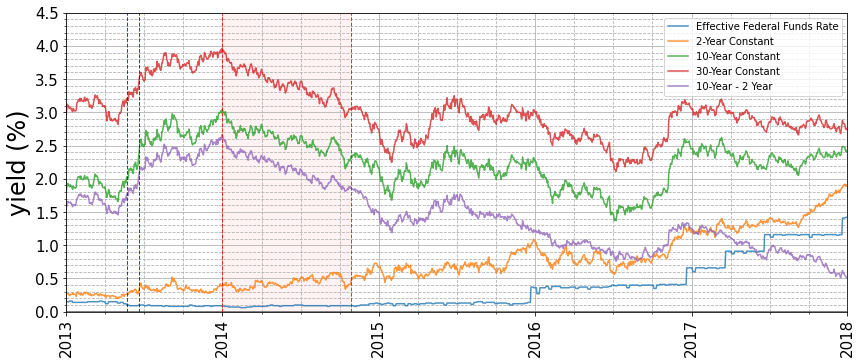

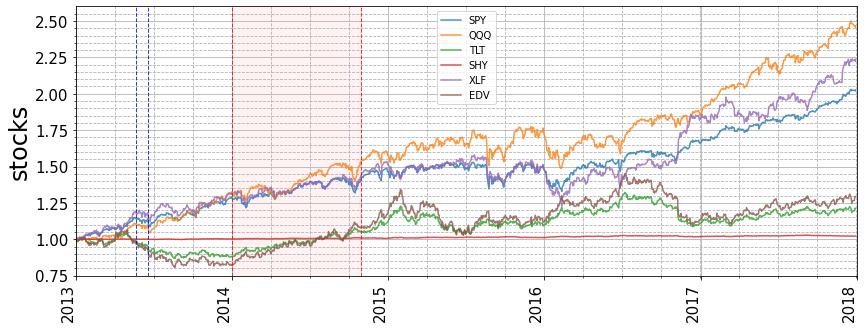

In [87]:
ytargets=["FF", "DGS2", "DGS10","DGS30","T10Y2Y"]
plot(df[ytargets],xlim=["2013-01-01", "2018-01-01"],ylim=[0,4.5], ylabel="yield (%)")

stargets= ["SPY", "QQQ", "TLT", "SHY","XLF","EDV"]
#stargets=tickers
plot(df[stargets],xlim=["2013-01-01", "2018-01-01"],ylim=[0.75,2.6], ylabel="stocks", normalize=True)

テーパリング開始から2年半を切り取って拡大しました。

- テーパリング期間もっとも成績が良いのは，SPYでもQQQでもなく，TLTやEDVなどの国債ETF(僕はTLTではなくEDVを買ってます)
- SPYやQQQと，国債ETF(TLT,EDV)が短期的には逆相関していることも，よく分かります。

ただ，今の長期金利は2014年頃と比べて低いので，今度のテーパリング時も国債ETFが良いかはよくわからない

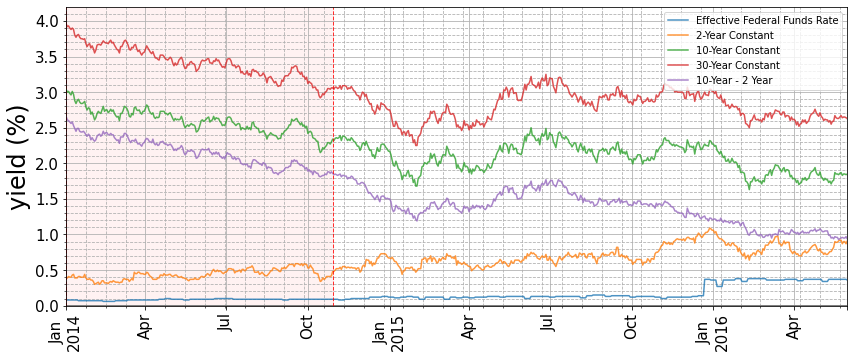

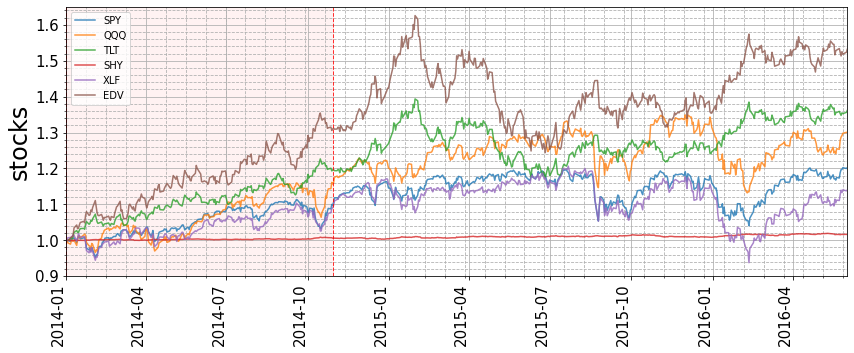

In [86]:
ytargets=["FF", "DGS2", "DGS10","DGS30","T10Y2Y"]
plot(df[ytargets],xlim=["2014-01-01", "2016-06-01"],ylim=[0,4.2], ylabel="yield (%)")

plot(df[stargets],xlim=["2014-01-01", "2016-06-01"],ylim=[0.9,1.65], ylabel="stocks", normalize=True)